# Third assignment: Network Robustness


# Part 1: Use small graphs to write the code

1. In the first part, you can use some graphs obtained by using the Networkx library or the library of your choice.
2. For each selected graph (max 2 or 3) you can perform different types of attack: turn off nodes at random, turn off the highest degree nodes, those with the highest pagerank, those with the highest betweenness, ...
2. After each removal, compute new measures, for example the size of the giant component or the diameter of the network and then plot these measures with respect to node failures. In case of networks of large size, often for the giant component S/N is plotted, e.g., the ratio between the size of the giant component and the size of the network.
2. Be careful, some of the functions you will use work only for undirected, connected graphs and therefore you need to instrument your code to work on the entire graph first, and then on the several components after the split of the original graph into smaller clusters.

In [1]:
%matplotlib inline
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from scipy.io import mmread
from scipy import integrate

In [2]:
def remove_random_nodes(G:nx.Graph, percentage:float) -> nx.Graph:
    """Remove a percentage of random nodes from the graph G and return the resulting graph.

    Args:
        G: A networkx graph.
        percentage: percentage of nodes to remove from G.

    Returns:
        A networkx graph.
    """
    if percentage < 0 or percentage > 1:
        raise Exception("Percentage must be between 0 and 1")
    if G.number_of_nodes() <= 0:
        return G

    initial_nodes = G.number_of_nodes()
    if initial_nodes > 0:
        # Get random nodes from G
        nodes = list(G.nodes)
        num = int(percentage * len(nodes))
        if num < 1:
            num = 1
        nodes = random.sample(nodes, num)
        # remove num nodes from G (if num > len(nodes), remove all nodes)
        G.remove_nodes_from(nodes[0:num])
    # Return the resulting graph
    return G if G.number_of_nodes() != initial_nodes else nx.Graph()

def remove_highest_degree_node(G:nx.Graph, percentage:float) -> nx.Graph:
    """Remove a percentage of nodes with the highest degree from the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        percentage: percentage of nodes to remove from G.
        
    Returns:
        A networkx graph.
    """
    if percentage < 0 or percentage > 1:
        raise Exception("Percentage must be between 0 and 1")
    if G.number_of_nodes() <= 0:
        return nx.Graph()
    
    initial_nodes = G.number_of_nodes()
    if initial_nodes > 0:
        # Get random nodes from G
        nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)
        num = int(percentage * len(nodes))
        if num < 1:
            num = 1
        nodes = [node[0] for node in nodes[0:num]]
        # remove num nodes from G (if num > len(nodes), remove all nodes)
        G.remove_nodes_from(nodes)
    # Return the resulting graph
    return G if G.number_of_nodes() != initial_nodes else nx.Graph()

def remove_highest_betweenness_node(G:nx.Graph, percentage:float) -> nx.Graph:
    """Remove a percentage of nodes with the highest betweenness centrality from the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        percentage: percentage of nodes to remove from G.
        
    Returns:
        A networkx graph.
    """
    if percentage < 0 or percentage > 1:
        raise Exception("Percentage must be between 0 and 1")
    if G.number_of_nodes() <= 0:
        return nx.Graph()
    
    initial_nodes = G.number_of_nodes()
    if initial_nodes > 0:
        # Get random nodes from G
        nodes = sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)
        num = int(percentage * len(nodes))
        if num < 1:
            num = 1
        nodes = [node[0] for node in nodes[0:num]]
        # remove num nodes from G (if num > len(nodes), remove all nodes)
        G.remove_nodes_from(nodes)
    # Return the resulting graph
    return G if G.number_of_nodes() != initial_nodes else nx.Graph()

def remove_highest_pagerank_node(G:nx.Graph, percentage:float) -> nx.Graph:
    """Remove a percentage of nodes with the highest PageRank from the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        percentage: percentage of nodes to remove from G.
        
    Returns:
        A networkx graph.
    """
    if percentage < 0 or percentage > 1:
        raise Exception("Percentage must be between 0 and 1")
    if G.number_of_nodes() <= 0:
        return nx.Graph()
    
    initial_nodes = G.number_of_nodes()
    if initial_nodes > 0:
        # Get random nodes from G
        nodes = sorted(nx.pagerank(G).items(), key=lambda x: x[1], reverse=True)
        num = int(percentage * len(nodes))
        if num < 1:
            num = 1
        nodes = [node[0] for node in nodes[0:num]]
        # remove num nodes from G (if num > len(nodes), remove all nodes)
        G.remove_nodes_from(nodes)
    # Return the resulting graph
    return G if G.number_of_nodes() != initial_nodes else nx.Graph()

def remove_highest_closeness_node(G: nx.Graph, percentage:float) -> nx.Graph:
    """Remove a percentage of nodes with the highest closeness centrality from the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        percentage: percentage of nodes to remove from G.
        
    Returns:
        A networkx graph.
    """
    if percentage < 0 or percentage > 1:
        raise Exception("Percentage must be between 0 and 1")
    if G.number_of_nodes() <= 0:
        return nx.Graph()
    
    initial_nodes = G.number_of_nodes()
    if initial_nodes > 0:
        # Get random nodes from G
        nodes = sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True)
        num = int(percentage * len(nodes))
        if num < 1:
            num = 1
        nodes = [node[0] for node in nodes[0:num]]
        # remove num nodes from G (if num > len(nodes), remove all nodes)
        G.remove_nodes_from(nodes)
    # Return the resulting graph
    return G if G.number_of_nodes() != initial_nodes else nx.Graph()

def get_lcc(G: nx.Graph) -> nx.Graph:
    """Get the largest connected component of the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        
    Returns:
        A networkx graph.
    """
    g = G.copy()
    # Get the largest connected component from G
    largest_comp = max(nx.connected_components(g), key=len) if len(G) > 0 else set()
    # Return the resulting graph
    return nx.Graph(g.subgraph(largest_comp))

def get_lcc_size(G: nx.Graph) -> int:
    """Deprecated. Use get_lcc instead."""
    raise Exception("Deprecated. Use get_lcc instead.")

def get_diameter(G: nx.Graph) -> int:
    """Get the diameter of the graph G and return the resulting diameter.
    
    Args:
        G: A networkx graph.
        
    Returns:
        An integer.
    """
    g_new = G.copy()
    if len(G) == 0:
        return 0
    if not nx.is_connected(G):
        g_new = G.subgraph(max(nx.connected_components(G), key=len))
    return nx.diameter(g_new) if len(g_new) > 0 else 0

In [20]:
def attack_random(G: nx.graph, percentage:float):
    g1 = G.copy()
    l1 = []
    d1 = []
    x1 = []
    print("g1")
    i = 0
    initial_nodes = g1.number_of_nodes()
    x1.append( i )
    l1.append( len(max(nx.connected_components(g1), key=len)) )
    d1.append( get_diameter(g1) )
    while g1.number_of_nodes() > 0:
        print(g1.number_of_nodes())
        x1.append( initial_nodes - g1.number_of_nodes() )
        l1.append( len(max(nx.connected_components(g1), key=len)) )
        d1.append( get_diameter(g1) )
        g1 = remove_random_nodes(g1, percentage)
        i += 1
    return l1, d1, x1

def attack_degree(G: nx.graph, percentage:float):
    g2 = G.copy()
    l2 = []
    d2 = []
    x2 = []
    print("g2")
    i = 0
    initial_nodes = g2.number_of_nodes()
    x2.append( i )
    l2.append( len(max(nx.connected_components(g2), key=len)) )
    d2.append( get_diameter(g2) )
    while g2.number_of_nodes() > 0:
        print(g2.number_of_nodes())
        x2.append( initial_nodes - g2.number_of_nodes() )
        l2.append( len(max(nx.connected_components(g2), key=len)) )
        d2.append( get_diameter(g2) )
        g2 = remove_highest_degree_node(g2, percentage)
        i += 1
    return l2, d2, x2

def attack_betweenness(G:nx.graph, percentage:float):
    g3 = G.copy()
    l3 = []
    d3 = []
    x3 = []
    print("g3")
    i = 0
    initial_nodes = g3.number_of_nodes()
    x3.append( i )
    l3.append( len(max(nx.connected_components(g3), key=len)) )
    d3.append( get_diameter(g3) )
    while g3.number_of_nodes() > 0:
        print(g3.number_of_nodes())
        x3.append( initial_nodes - g3.number_of_nodes() )
        l3.append( len(max(nx.connected_components(g3), key=len)) )
        d3.append( get_diameter(g3) )
        g3 = remove_highest_betweenness_node(g3, percentage)
        i += 1
    return l3, d3, x3

def attack_pagerank(G:nx.graph, percentage:float):
    g4 = G.copy()
    l4 = []
    d4 = []
    x4 = []
    print("g4")
    i = 0
    initial_nodes = g4.number_of_nodes()
    x4.append( i )
    l4.append( len(max(nx.connected_components(g4), key=len)) )
    d4.append( get_diameter(g4) )
    while g4.number_of_nodes() > 0:
        print(g4.number_of_nodes())
        x4.append( initial_nodes - g4.number_of_nodes() )
        l4.append( len(max(nx.connected_components(g4), key=len)) )
        d4.append( get_diameter(g4) )
        g4 = remove_highest_pagerank_node(g4, percentage)
        i += 1
    return l4, d4, x4

def attack_closeness(G:nx.graph, percentage:float):
    g5 = G.copy()
    l5 = []
    d5 = []
    x5 = []
    print("g5")
    i = 0
    initial_nodes = g5.number_of_nodes()
    x5.append( i )
    l5.append( len(max(nx.connected_components(g5), key=len)) )
    d5.append( get_diameter(g5) )
    while g5.number_of_nodes() > 0:
        print(g5.number_of_nodes())
        x5.append( initial_nodes - g5.number_of_nodes() )
        l5.append( len(max(nx.connected_components(g5), key=len)) )
        d5.append( get_diameter(g5) )
        g5 = remove_highest_closeness_node(g5, percentage)
        i += 1
    return l5, d5, x5

def plot_results(total_nodes, nodes_per_iteration,
        x1:list=None, l1:list=None, d1:list=None,
        x2:list=None, l2:list=None, d2:list=None,
        x3:list=None, l3:list=None, d3:list=None,
        x4:list=None, l4:list=None, d4:list=None,
        x5:list=None, l5:list=None, d5:list=None):
    
    # scale x axis from 0 to 1
    x1 = [x/total_nodes for x in x1]
    x2 = [x/total_nodes for x in x2]
    x3 = [x/total_nodes for x in x3]
    x4 = [x/total_nodes for x in x4]
    x5 = [x/total_nodes for x in x5]
    
    plt.figure(figsize=(16,16), dpi=300)
    plt.subplot(2, 1, 1)
    plt.title('Largest connected component size vs percentage of nodes removed')
    plt.plot(x1, l1, label='random')
    plt.plot(x2, l2, label='highest degree')
    plt.plot(x3, l3, label='highest betweenness')
    plt.plot(x4, l4, label='highest pagerank')
    plt.plot(x5, l5, label='highest closeness')
    plt.xlabel('percentage of nodes removed')
    plt.ylabel('giant component size')
    plt.grid()
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title('Diameter vs percentage of nodes removed')
    plt.plot(x1, d1, label='random', )
    plt.plot(x2, d2, label='highest degree')
    plt.plot(x3, d3, label='highest betweenness')
    plt.plot(x4, d4, label='highest pagerank')
    plt.plot(x5, d5, label='highest closeness')
    plt.xlabel('percentage of nodes removed')
    plt.ylabel('diameter')
    plt.grid()
    plt.legend()
    plt.show()



In [37]:

### Reading graph ###
# n=100
# p=0.1
# k=5
# G=nx.erdos_renyi_graph(n, p)
#G = nx.watts_strogatz_graph(n, k, p)

read_file = mmread('power-bcspwr10.mtx')
G = nx.Graph(read_file)
G.remove_edges_from(nx.selfloop_edges(G))

n = G.number_of_nodes()

In [38]:
percentage = 0.1

In [39]:
l1, d1, x1 = attack_random(G, percentage)

g1
5300
4770
4293
3864
3478
3131
2818
2537
2284
2056
1851
1666
1500
1350
1215
1094
985
887
799
720
648
584
526
474
427
385
347
313
282
254
229
207
187
169
153
138
125
113
102
92
83
75
68
62
56
51
46
42
38
35
32
29
27
25
23
21
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [40]:
l2, d2, x2 = attack_degree(G, percentage)

g2
5300
4770
4293
3864
3478
3131
2818
2537
2284
2056
1851
1666
1500
1350
1215
1094
985
887
799
720
648
584
526
474
427
385
347
313
282
254
229
207
187
169
153
138
125
113
102
92
83
75
68
62
56
51
46
42
38
35
32
29
27
25
23
21
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [41]:
l3, d3, x3 = attack_betweenness(G, percentage)

g3
5300
4770
4293
3864
3478
3131
2818
2537
2284
2056
1851
1666
1500
1350
1215
1094
985
887
799
720
648
584
526
474
427
385
347
313
282
254
229
207
187
169
153
138
125
113
102
92
83
75
68
62
56
51
46
42
38
35
32
29
27
25
23
21
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [42]:
l4, d4, x4 = attack_pagerank(G, percentage)

g4
5300
4770
4293
3864
3478
3131
2818
2537
2284
2056
1851
1666
1500
1350
1215
1094
985
887
799
720
648
584
526
474
427
385
347
313
282
254
229
207
187
169
153
138
125
113
102
92
83
75
68
62
56
51
46
42
38
35
32
29
27
25
23
21
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [43]:
l5, d5, x5 = attack_closeness(G, percentage)

g5
5300
4770
4293
3864
3478
3131
2818
2537
2284
2056
1851
1666
1500
1350
1215
1094
985
887
799
720
648
584
526
474
427
385
347
313
282
254
229
207
187
169
153
138
125
113
102
92
83
75
68
62
56
51
46
42
38
35
32
29
27
25
23
21
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


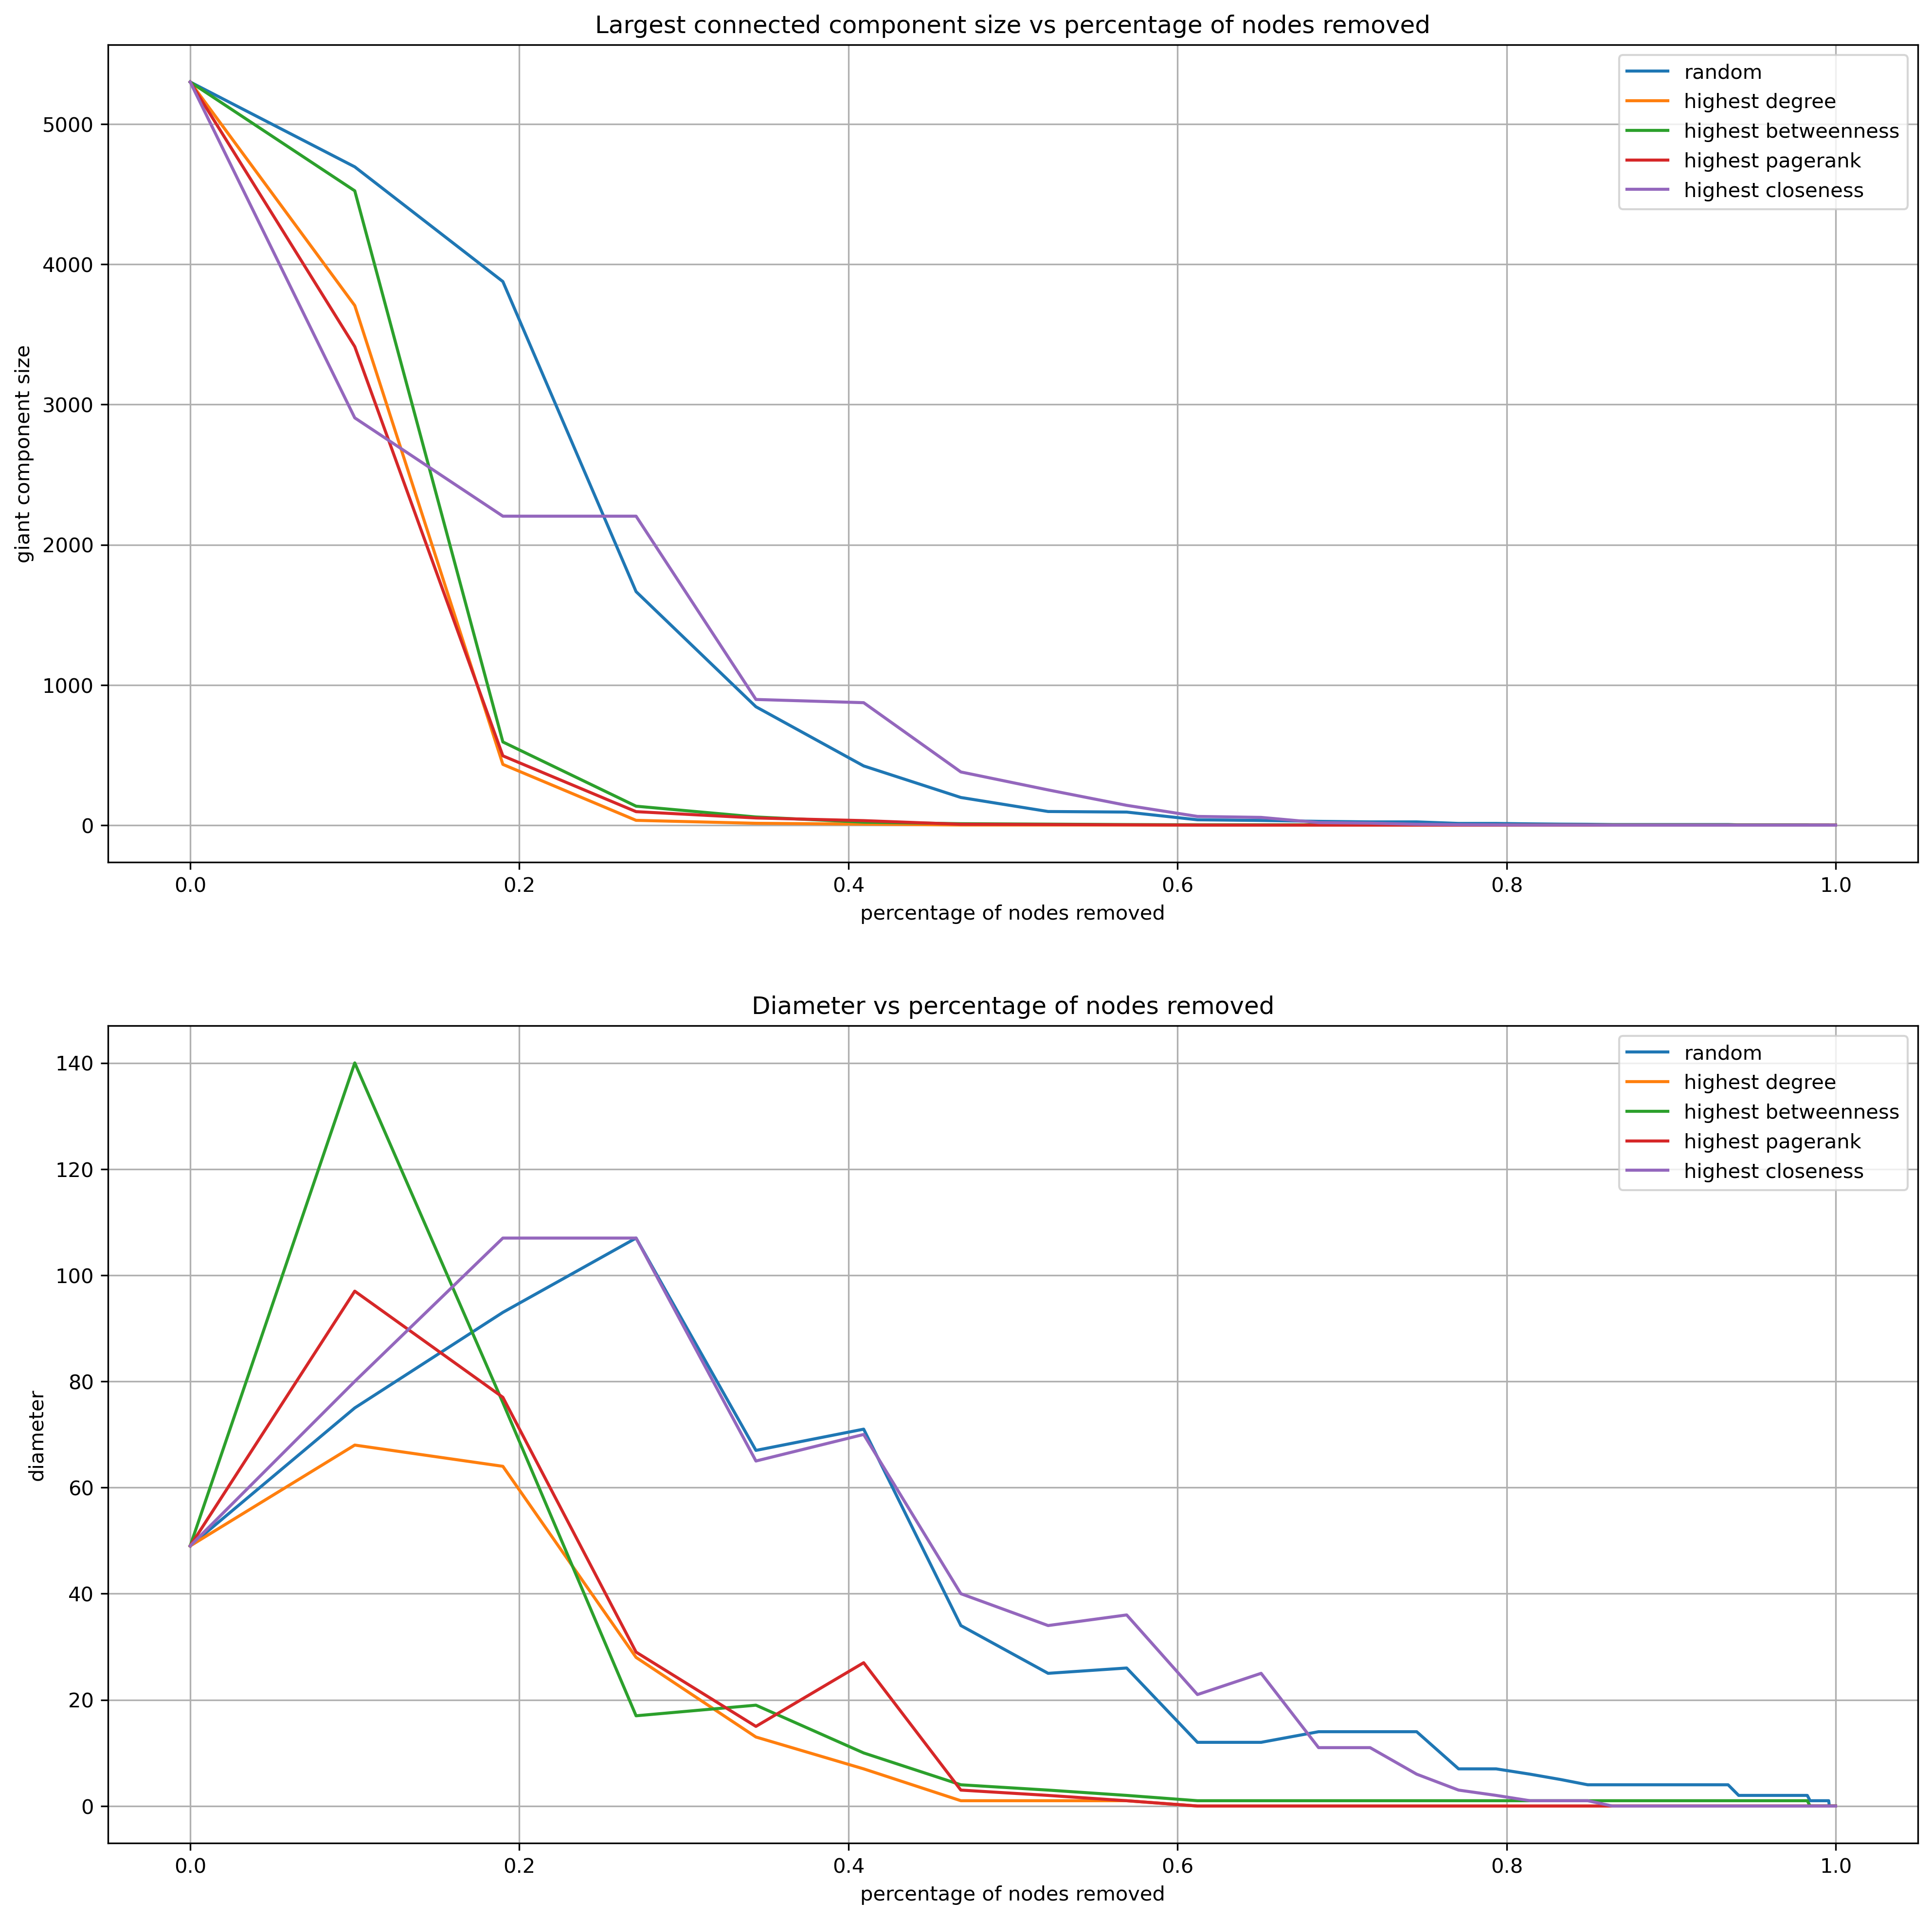

In [44]:
plot_results(total_nodes=n, nodes_per_iteration=percentage,
    x1=x1, l1=l1, d1=d1
    ,x2=x2, l2=l2, d2=d2
    ,x3=x3, l3=l3, d3=d3
    ,x4=x4, l4=l4, d4=d4
    ,x5=x5, l5=l5, d5=d5
    )